# Stress Level Prediction – MLP & NCF Models
This notebook loads the dataset, preprocesses it, trains MLP and NCF models, and evaluates performance.

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Concatenate
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
df = pd.read_csv('dataset_prediksi_stres_200.csv')
df.head()

,employee_id,department,workload,work_life_balance,team_conflict,management_support,work_environment,stress_level
0,EMP0001,HR,9,10,3,5,5,13
1,EMP0002,Finance,8,4,7,6,2,15
2,EMP0003,Finance,10,5,4,7,5,21
3,EMP0004,Marketing,1,10,9,6,1,52
4,EMP0005,IT,1,8,5,7,10,28


## Preprocessing

In [8]:
def classify_level(x):
    if x <= 20: return 0
    elif x <= 40: return 1
    else: return 2

df['label'] = df['stress_level'].apply(classify_level)

le_dept = LabelEncoder()
df['dept_enc'] = le_dept.fit_transform(df['department'])

features = ['workload','work_life_balance','team_conflict','management_support','work_environment']
X = df[features]
y = df['label']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
y_train_cat = to_categorical(y_train, 3)
y_test_cat = to_categorical(y_test, 3)

df.head()

,employee_id,department,workload,work_life_balance,team_conflict,management_support,work_environment,stress_level,label,dept_enc
0,EMP0001,HR,9,10,3,5,5,13,0,1
1,EMP0002,Finance,8,4,7,6,2,15,0,0
2,EMP0003,Finance,10,5,4,7,5,21,1,0
3,EMP0004,Marketing,1,10,9,6,1,52,2,3
4,EMP0005,IT,1,8,5,7,10,28,1,2


## MLP Model

In [9]:
inp = Input(shape=(X_train.shape[1],))
x = Dense(32, activation='relu')(inp)
x = Dense(16, activation='relu')(x)
out = Dense(3, activation='softmax')(x)
mlp = Model(inp, out)
mlp.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = mlp.fit(X_train, y_train_cat, epochs=50, batch_size=16, validation_split=0.2, verbose=0)
y_pred = np.argmax(mlp.predict(X_test), axis=1)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x7f92103f9440> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Accuracy: 0.55
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.25      0.11      0.15         9
           2       0.60  

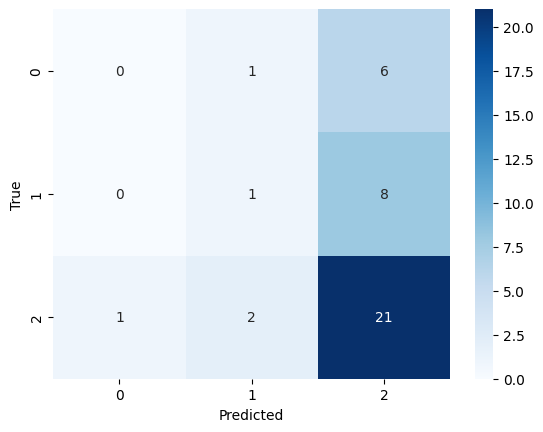

In [10]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

## Neural Collaborative Filtering (NCF)

In [11]:
user_enc = LabelEncoder()
df['user_enc'] = user_enc.fit_transform(df['employee_id'])
num_users = df['user_enc'].nunique()
num_items = df['dept_enc'].nunique()

X_user = df['user_enc']
X_item = df['dept_enc']
y2 = df['label']

X_user_train, X_user_test, X_item_train, X_item_test, y2_train, y2_test = train_test_split(
    X_user, X_item, y2, test_size=0.2, random_state=42)

y2_train_cat = to_categorical(y2_train, 3)
y2_test_cat = to_categorical(y2_test, 3)

user_in = Input(shape=(1,))
item_in = Input(shape=(1,))
user_emb = Embedding(num_users, 16)(user_in)
item_emb = Embedding(num_items, 16)(item_in)
u = Flatten()(user_emb)
i = Flatten()(item_emb)
concat = Concatenate()([u, i])
x = Dense(32, activation='relu')(concat)
x = Dense(16, activation='relu')(x)
out = Dense(3, activation='softmax')(x)
ncf = Model([user_in, item_in], out)
ncf.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])
ncf.fit([X_user_train, X_item_train], y2_train_cat, epochs=50, batch_size=16, verbose=0)
y2_pred = np.argmax(ncf.predict([X_user_test, X_item_test]), axis=1)
print("NCF Accuracy:", accuracy_score(y2_test, y2_pred))
print(classification_report(y2_test, y2_pred))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
NCF Accuracy: 0.525
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.33      0.22      0.27         9
           2       0.68      0.79      0.73        24

    accuracy                           0.53        40
   macro avg       0.34      0.34      0.33        40
weighted avg       0.48      0.53      0.50        40

